# Hyperparameter Optimization for Tree Ensemble with Uncertainty Quantification (Scikit-Learn)

In this tutorial, we will see how to use Hyperparameter optimization to generate ensemble of models that can be used for uncertainty quantification.

In [1]:
import matplotlib.pyplot as plt

WIDTH_PLOTS = 8
HEIGHT_PLOTS = WIDTH_PLOTS / 1.618

## Data

For the data, we use the ``make_moons`` functionality from Scikit-Learn to have a binary-classification problem.

In addition, we randomly flip 10% of the labels to generate artificial noise (later corresponding to aleatoric uncertainty).

In [2]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split


# Dataset
def flip_binary_labels(y, ratio, random_state=None):
    """Increase the variance of P(Y|X) by ``ratio``"""
    y_flipped = np.zeros(np.shape(y))
    y_flipped[:] = y[:]
    rs = np.random.RandomState(random_state)
    idx = np.arange(len(y_flipped))
    idx = rs.choice(idx, size=int(ratio * len(y_flipped)), replace=False)
    y_flipped[idx] = 1 - y_flipped[idx]
    return y_flipped


def load_data_train_test(random_state=42):
    noise = 0.1
    n = 1_000
    ratio_flipped = 0.1  # 10% of the labels are flipped

    rng = np.random.RandomState(random_state)

    # Moons
    make_dataset = lambda n, seed: make_moons(
        n_samples=n,
        noise=noise,
        shuffle=True,
        random_state=seed,
    )

    X, y = make_dataset(n, rng.randint(2**31))
    center = np.mean(X, axis=0)
    X = X - center

    y = flip_binary_labels(y, ratio=ratio_flipped, random_state=rng.randint(2**31))
    y = y.astype(np.int64)

    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=0.33, random_state=rng.randint(2**31), stratify=y
    )

    return (train_X, train_y), (test_X, test_y)


def load_data_train_valid(verbose=0, random_state=42):

    (x, y), _ = load_data_train_test(random_state=random_state)

    train_X, valid_X, train_y, valid_y = train_test_split(
        x, y, test_size=0.33, random_state=random_state, stratify=y
    )

    if verbose:
        print(f"train_X shape: {np.shape(train_X)}")
        print(f"train_y shape: {np.shape(train_y)}")
        print(f"valid_X shape: {np.shape(valid_X)}")
        print(f"valid_y shape: {np.shape(valid_y)}")
    return (train_X, train_y), (valid_X, valid_y)

train_X shape: (448, 2)
train_y shape: (448,)
valid_X shape: (222, 2)
valid_y shape: (222,)


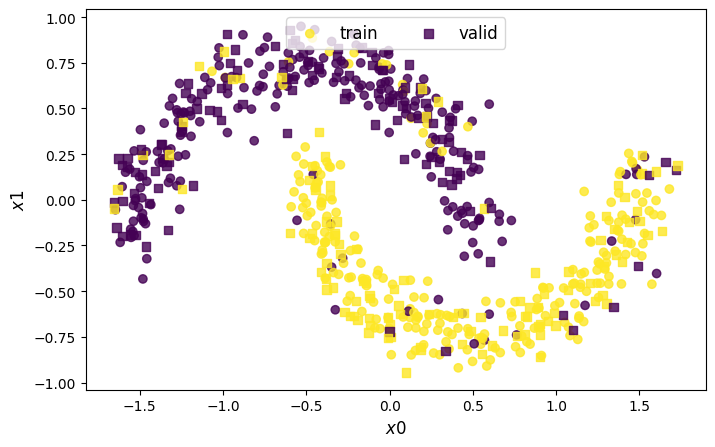

In [3]:
(x, y), (vx, vy) = load_data_train_valid(verbose=1)
_, (tx, ty) = load_data_train_test()

plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

plt.scatter(
    x[:, 0].reshape(-1), x[:, 1].reshape(-1), c=y, label="train", alpha=0.8
)
plt.scatter(
    vx[:, 0].reshape(-1),
    vx[:, 1].reshape(-1),
    c=vy,
    marker="s",
    label="valid",
    alpha=0.8,
)

plt.ylabel("$x1$", fontsize=12)
plt.xlabel("$x0$", fontsize=12)

plt.legend(loc="upper center", ncol=3, fontsize=12)

plt.show()


## Training and Scoring of Decision Tree

The class of model we use in this tutorial is Decision Tree.

In this part, we will see how to train and evaluate such models.

In [4]:
def plot_decision_boundary_decision_tree(dataset, labels, model, steps=1000, color_map="viridis"):
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    labels_predicted = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Plot decision boundary in region of interest
    z = labels_predicted[:, 1].reshape(xx.shape)

    ax = plt.gca()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)

    # Get predicted labels on training data and plot
    ax.scatter(
        dataset[:, 0],
        dataset[:, 1],
        c=labels,
        # cmap=color_map,
        lw=0,
    )
    plt.show()

In [29]:
import pathlib
import pickle
import os

from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import log_loss, accuracy_score
from sklearn.tree import DecisionTreeClassifier

hpo_dir = "hpo_sklearn_classification"
model_checkpoint_dir = os.path.join(hpo_dir, "models")


def run(job, model_checkpoint_dir=".", verbose=True, show_plots=False):

    (x, y), (vx, vy) = load_data_train_valid(verbose=verbose)
    _, (tx, ty) = load_data_train_test()

    model = DecisionTreeClassifier(**job.parameters)

    if verbose:
        print(model)

    try:
        model.fit(x, y)
        vy_pred_proba = model.predict_proba(vx)
        val_cce = log_loss(vy, vy_pred_proba)
    except:
        return "F_fit"

    # Saving the model
    with open(os.path.join(model_checkpoint_dir, f"model_{job.id}.pkl"), "wb") as f:
        pickle.dump(model, f)

    if verbose:
        print(f"{job.id}: {val_cce=:.3f}")

    if show_plots:
        plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
        plot_decision_boundary_decision_tree(
            tx, ty, model, steps=1000, color_map="viridis"
        )
        plt.show()

        plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
        disp = CalibrationDisplay.from_predictions(ty, model.predict_proba(tx)[:, 1])
        plt.show()

    test_cce = log_loss(ty, model.predict_proba(tx))
    test_acc = accuracy_score(ty, model.predict(tx))

    # The score is negated for maximization
    # The score is -Categorical Cross Entropy/LogLoss
    return {
        "objective": -val_cce,
        "metadata": {"test_cce": test_cce, "test_acc": test_acc},
    }

## Hyperparameter Optimization Search Space

We now define the hyperparameter optimization search space for decision trees.

In [17]:
from deephyper.hpo import HpProblem


def create_hpo_problem():

    problem = HpProblem()

    problem.add_hyperparameter(["gini", "entropy", "log_loss"], "criterion")
    problem.add_hyperparameter(["best", "random"], "splitter")
    problem.add_hyperparameter((10, 1000, "log-uniform"), "max_depth", default_value=1000)
    problem.add_hyperparameter((2, 20), "min_samples_split", default_value=2)
    problem.add_hyperparameter((1, 20), "min_samples_leaf", default_value=1)
    problem.add_hyperparameter((0.0, 0.5), "min_weight_fraction_leaf", default_value=0.0)

    return problem

create_hpo_problem()

Configuration space object:
  Hyperparameters:
    criterion, Type: Categorical, Choices: {gini, entropy, log_loss}, Default: gini
    max_depth, Type: UniformInteger, Range: [10, 1000], Default: 1000, on log-scale
    min_samples_leaf, Type: UniformInteger, Range: [1, 20], Default: 1
    min_samples_split, Type: UniformInteger, Range: [2, 20], Default: 2
    min_weight_fraction_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0
    splitter, Type: Categorical, Choices: {best, random}, Default: best

## The Baseline Decision Tree

Now, we evaluate the baseline Decision Tree model by test `default_value` hyperparameters.

In [18]:
from deephyper.evaluator import RunningJob


def evaluate_decision_tree():

    model_checkpoint_dir = "models_sklearn_test"
    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    problem = create_hpo_problem()
    print(problem)

    default_parameters = problem.default_configuration
    print(f"{default_parameters=}")
    
    output = run(
        RunningJob(id="test", parameters=default_parameters),
        model_checkpoint_dir=model_checkpoint_dir,
        show_plots=True,
    )
    print(f"{output=}")

Configuration space object:
  Hyperparameters:
    criterion, Type: Categorical, Choices: {gini, entropy, log_loss}, Default: gini
    max_depth, Type: UniformInteger, Range: [10, 1000], Default: 1000, on log-scale
    min_samples_leaf, Type: UniformInteger, Range: [1, 20], Default: 1
    min_samples_split, Type: UniformInteger, Range: [2, 20], Default: 2
    min_weight_fraction_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0
    splitter, Type: Categorical, Choices: {best, random}, Default: best

default_parameters={'criterion': 'gini', 'max_depth': 1000, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
train_X shape: (448, 2)
train_y shape: (448,)
valid_X shape: (222, 2)
valid_y shape: (222,)
DecisionTreeClassifier(max_depth=1000)
0.0: val_cce=6.657


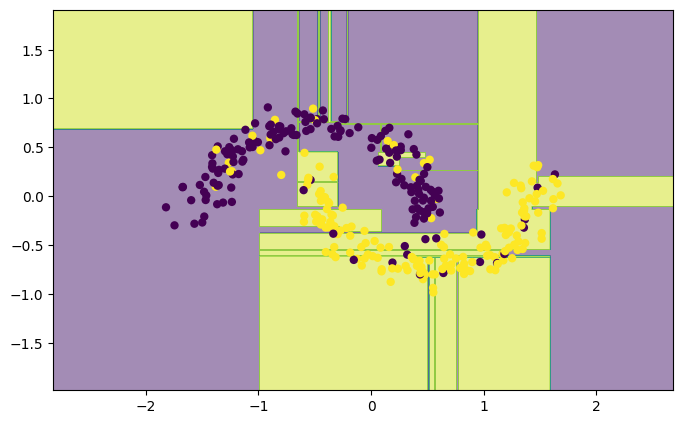

<Figure size 800x494.438 with 0 Axes>

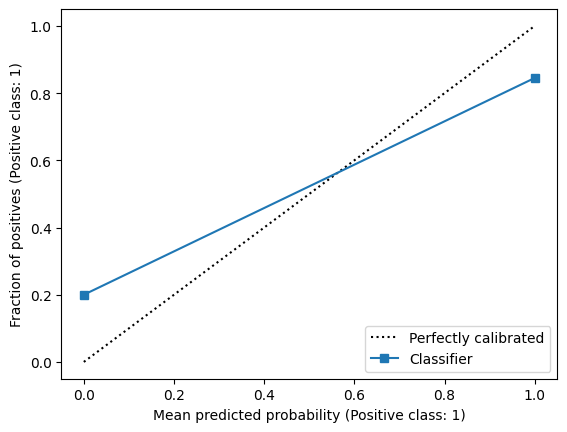

output={'objective': -6.656710761053167, 'metadata': {'test_cce': 6.444168333205793, 'test_acc': 0.8212121212121212}}


In [19]:
evaluate_decision_tree()

The accuracy is great, but the 

## Hyperparameter Optimization

In [21]:
from deephyper.hpo import CBO
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback


def run_hpo():

    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    problem = create_hpo_problem()

    evaluator = Evaluator.create(
        run,
        method="ray",
        method_kwargs={
            "num_cpus": 8,
            "num_cpus_per_task": 1,
            "run_function_kwargs": {
                "model_checkpoint_dir": model_checkpoint_dir,
                "verbose": False,
            },
            "callbacks": [TqdmCallback()]
        },
    )
    search = CBO(
        problem,
        evaluator,
        log_dir=hpo_dir,
        initial_points=[problem.default_configuration],
        kappa=5.0,
        scheduler={"type": "periodic-exp-decay", "period": 50, "kappa_final": 0.0001},
        objective_scaler="identity",
    )

    results = search.search(max_evals=1_000)

    return results

In [22]:
results = run_hpo()

2024-09-09 11:43:00,396	INFO worker.py:1788 -- Started a local Ray instance.
/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:132: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
results

,p:criterion,p:max_depth,p:min_samples_leaf,p:min_samples_split,p:min_weight_fraction_leaf,p:splitter,objective,job_id,m:timestamp_submit,m:test_cce,m:test_acc,m:timestamp_gather
0,gini,11,5,16,0.112087,random,-0.468227,2,1.320261,0.463396,0.824242,2.752158
1,log_loss,38,20,5,0.387330,best,-0.501469,3,1.321214,0.537959,0.766667,2.801366
2,log_loss,750,14,11,0.471634,random,-0.693107,1,1.318783,0.693133,0.503030,2.804488
3,entropy,424,20,6,0.371676,random,-0.491318,4,1.322051,0.560768,0.751515,2.807934
4,entropy,423,20,5,0.419173,best,-0.489291,6,1.323944,0.565847,0.748485,2.810522
...,...,...,...,...,...,...,...,...,...,...,...,...
995,log_loss,20,12,4,0.266540,best,-0.471438,999,214.269917,0.522736,0.766667,214.534631
996,log_loss,13,14,16,0.258159,best,-0.471438,993,214.264277,0.522736,0.766667,214.537827
997,log_loss,10,11,16,0.255845,best,-0.471438,997,214.268237,0.522736,0.766667,214.545583
998,log_loss,13,3,16,0.261057,best,-0.471438,994,214.265483,0.522736,0.766667,214.549450


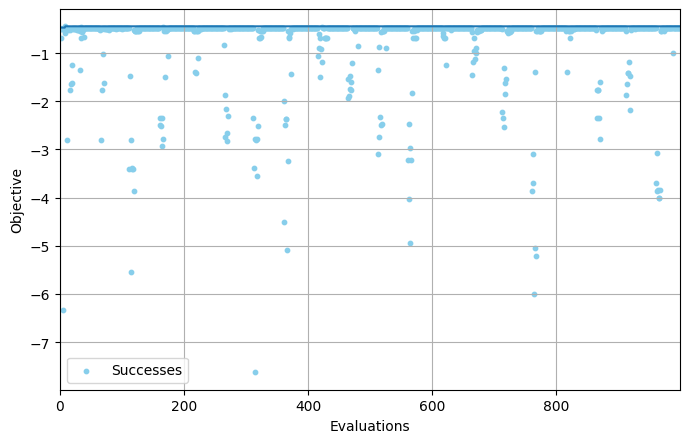

In [24]:
from deephyper.analysis.hpo import plot_search_trajectory_single_objective_hpo

plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plot_search_trajectory_single_objective_hpo(results)
plt.show()

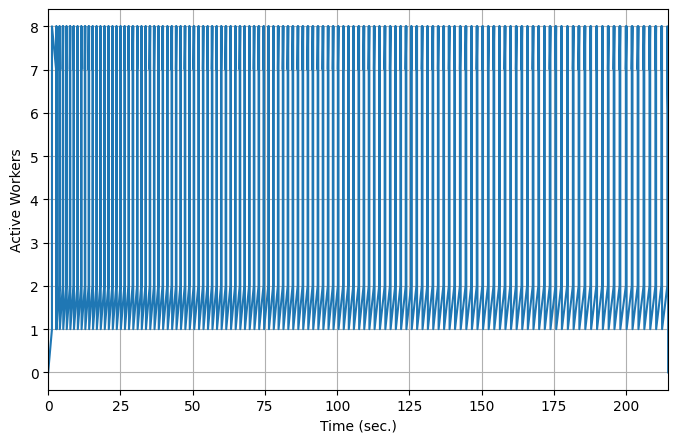

In [25]:
from deephyper.analysis.hpo import plot_worker_utilization

plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plot_worker_utilization(results)
plt.show()

## The Best Decision Tree

In [26]:
from deephyper.analysis.hpo import parameters_from_row

topk_rows = results.nlargest(5, "objective").reset_index(drop=True)

for i, row in topk_rows.iterrows():
    parameters = parameters_from_row(row)
    value = row["objective"]
    print(f"Top-{i+1} -> {value=:.3f}: {parameters}")
    print()

Top-1 -> value=-0.441: {'criterion': 'gini', 'max_depth': 72, 'min_samples_leaf': 20, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0081770783870863, 'splitter': 'random'}

Top-2 -> value=-0.453: {'criterion': 'log_loss', 'max_depth': 922, 'min_samples_leaf': 3, 'min_samples_split': 11, 'min_weight_fraction_leaf': 0.0296010319524784, 'splitter': 'random'}

Top-3 -> value=-0.455: {'criterion': 'entropy', 'max_depth': 907, 'min_samples_leaf': 20, 'min_samples_split': 12, 'min_weight_fraction_leaf': 0.0010981705180883, 'splitter': 'random'}

Top-4 -> value=-0.462: {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 10, 'min_samples_split': 19, 'min_weight_fraction_leaf': 0.1150008130396404, 'splitter': 'random'}

Top-5 -> value=-0.468: {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 5, 'min_samples_split': 16, 'min_weight_fraction_leaf': 0.112086763310867, 'splitter': 'random'}



In [27]:
best_job = topk_rows.iloc[0]

hpo_dir = "hpo_sklearn_classification"
model_checkpoint_dir = os.path.join(hpo_dir, "models")

with open(os.path.join(model_checkpoint_dir, f"model_0.{best_job.job_id}.pkl"), "rb") as f:
    best_model = pickle.load(f)

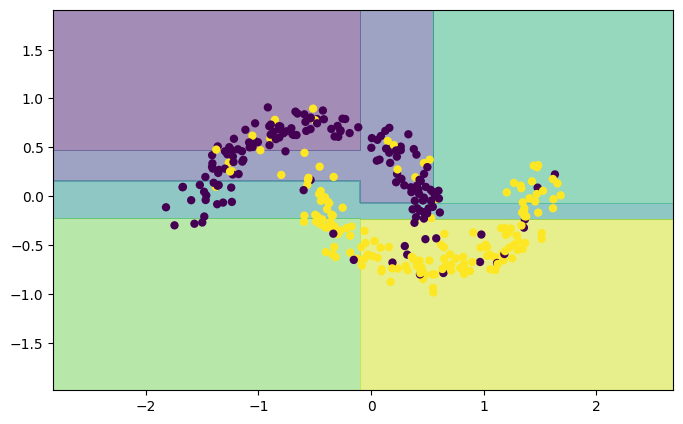

In [28]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

plot_decision_boundary_decision_tree(
    tx, ty, best_model, steps=1000, color_map="viridis"
)

<Figure size 800x494.438 with 0 Axes>

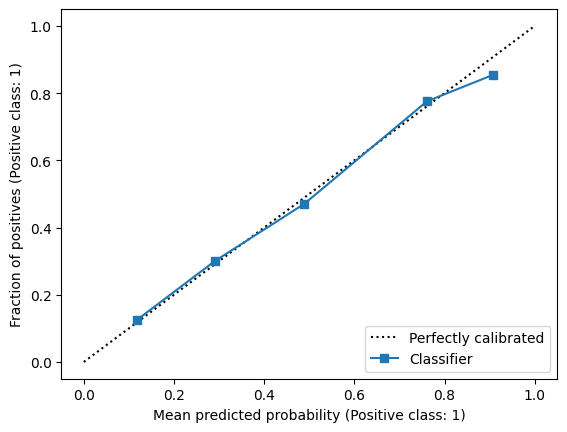

In [30]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
disp = CalibrationDisplay.from_predictions(ty, best_model.predict_proba(tx)[:, 1])
plt.show()

## Ensemble of Decision Trees

In [31]:
from deephyper.ensemble import EnsemblePredictor
from deephyper.ensemble.aggregator import MixedCategoricalAggregator
from deephyper.ensemble.loss import CategoricalCrossEntropy 
from deephyper.ensemble.selector import GreedySelector, TopKSelector
from deephyper.predictor.sklearn import SklearnPredictorFileLoader

In [32]:
def plot_decision_boundary_and_uncertainty(
    dataset, labels, model, steps=1000, color_map="viridis", s=5
):

    fig, axs = plt.subplots(
        3, sharex="all", sharey="all", figsize=(WIDTH_PLOTS, HEIGHT_PLOTS * 2)
    )

    # Define region of interest by data limits
    xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    y_pred = model.predict(np.c_[xx.ravel(), yy.ravel()].astype(np.float32))
    y_pred_proba = y_pred["loc"]
    y_pred_aleatoric = y_pred["uncertainty_aleatoric"]
    y_pred_epistemic = y_pred["uncertainty_epistemic"]

    # Plot decision boundary in region of interest

    # 1. MODE
    color_map = plt.get_cmap("viridis")
    z = y_pred_proba[:, 1].reshape(xx.shape)

    cont = axs[0].contourf(xx, yy, z, cmap=color_map, vmin=0, vmax=1, alpha=0.5)

    # Get predicted labels on training data and plot
    axs[0].scatter(
        dataset[:, 0],
        dataset[:, 1],
        c=labels,
        cmap=color_map,
        s=s,
        lw=0,
    )
    plt.colorbar(cont, ax=axs[0], label="Probability of class 1")

    # 2. ALEATORIC
    color_map = plt.get_cmap("plasma")
    z = y_pred_aleatoric.reshape(xx.shape)

    cont = axs[1].contourf(xx, yy, z, cmap=color_map, vmin=0, vmax=0.69, alpha=0.5)

    # Get predicted labels on training data and plot
    axs[1].scatter(
        dataset[:, 0],
        dataset[:, 1],
        c=labels,
        cmap=color_map,
        s=s,
        lw=0,
    )
    plt.colorbar(cont, ax=axs[1], label="Aleatoric uncertainty")

    # 3. EPISTEMIC
    z = y_pred_epistemic.reshape(xx.shape)

    cont = axs[2].contourf(xx, yy, z, cmap=color_map, vmin=0, vmax=0.69, alpha=0.5)

    # Get predicted labels on training data and plot
    axs[2].scatter(
        dataset[:, 0],
        dataset[:, 1],
        c=labels,
        cmap=color_map,
        s=s,
        lw=0,
    )
    plt.colorbar(cont, ax=axs[2], label="Epistemic uncertainty")

    plt.show()

In [51]:
def create_ensemble_from_checkpoints(ensemble_selector: str = "topk"):

    # 0. Load data
    _, (vx, vy) = load_data_train_valid(verbose=0)

    # !1.3 SKLEARN EXAMPLE
    predictor_files = SklearnPredictorFileLoader.find_predictor_files(
        model_checkpoint_dir
    )
    predictor_loaders = [SklearnPredictorFileLoader(f) for f in predictor_files]
    predictors = [p.load() for p in predictor_loaders]

    # 2. Build an ensemble
    ensemble = EnsemblePredictor(
        predictors=predictors,
        aggregator=MixedCategoricalAggregator(
            uncertainty_method="entropy", decomposed_uncertainty=True
        ),
        # ! You can specify parallel backends for the evaluation of the ensemble
        evaluator={
            "method": "process",
            "method_kwargs": {"num_workers": 8},
        },
    )
    y_predictors = ensemble.predictions_from_predictors(
        vx, predictors=ensemble.predictors
    )

    # Use TopK or Greedy/Caruana
    if ensemble_selector == "topk":
        selector = TopKSelector(
            loss_func=CategoricalCrossEntropy(),
            k=20,
        )
    elif ensemble_selector == "greedy":
        selector = GreedySelector(
            loss_func=CategoricalCrossEntropy(),
            aggregator=MixedCategoricalAggregator(),
            k=20,
            k_init=5,
            eps_tol=1e-5,
        )
    else:
        raise ValueError(f"Unknown ensemble_selector: {ensemble_selector}")

    selected_predictors_indexes, selected_predictors_weights = selector.select(
        vy, y_predictors
    )
    print(f"{selected_predictors_indexes=}")
    print(f"{selected_predictors_weights=}")

    ensemble.predictors = [ensemble.predictors[i] for i in selected_predictors_indexes]
    ensemble.weights = selected_predictors_weights

    return ensemble

In [52]:
ensemble = create_ensemble_from_checkpoints("topk")

selected_predictors_indexes=[745, 60, 953, 747, 14, 0, 571, 572, 576, 577, 580, 584, 585, 586, 587, 590, 591, 592, 595, 596]
selected_predictors_weights=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


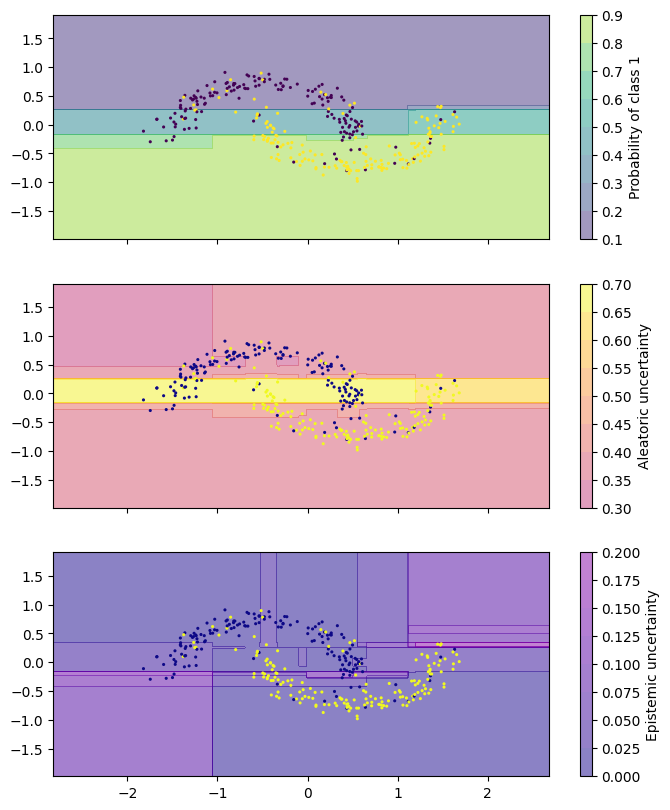

cce=0.490, acc=0.812


In [53]:
plot_decision_boundary_and_uncertainty(tx, ty, ensemble, steps=1000, color_map="viridis")

ty_pred = ensemble.predict(tx)["loc"]

cce = log_loss(ty, ty_pred)
acc = accuracy_score(ty, np.argmax(ty_pred, axis=1))

print(f"{cce=:.3f}, {acc=:.3f}")

<Figure size 800x494.438 with 0 Axes>

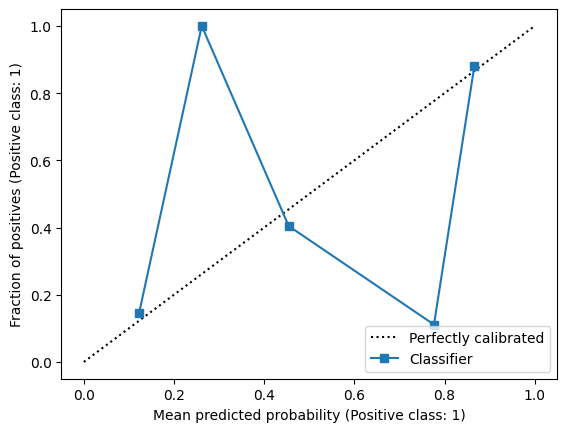

In [54]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
disp = CalibrationDisplay.from_predictions(ty, ty_pred[:, 1])
plt.show()

In [55]:
ensemble = create_ensemble_from_checkpoints("greedy")

selected_predictors_indexes=[14, 60, 277, 383, 559, 564, 619, 716, 745, 747, 776, 852, 872, 882, 931, 953, 966]
selected_predictors_weights=[0.009259259259259259, 0.009259259259259259, 0.06481481481481481, 0.046296296296296294, 0.12962962962962962, 0.027777777777777776, 0.009259259259259259, 0.18518518518518517, 0.009259259259259259, 0.009259259259259259, 0.018518518518518517, 0.027777777777777776, 0.37037037037037035, 0.027777777777777776, 0.018518518518518517, 0.009259259259259259, 0.027777777777777776]


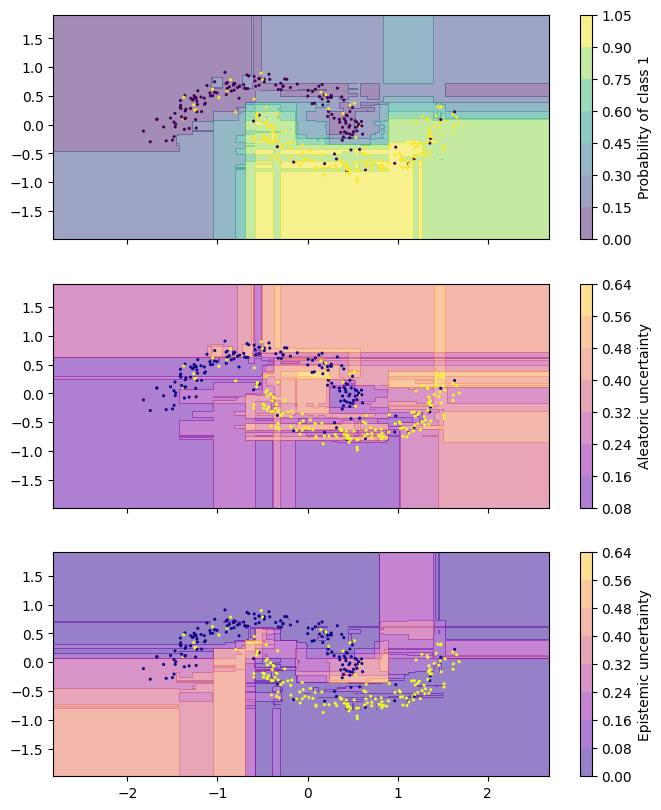

cce=0.402, acc=0.873


In [56]:
plot_decision_boundary_and_uncertainty(tx, ty, ensemble, steps=1000, color_map="viridis")

ty_pred = ensemble.predict(tx)["loc"]

cce = log_loss(ty, ty_pred)
acc = accuracy_score(ty, np.argmax(ty_pred, axis=1))

print(f"{cce=:.3f}, {acc=:.3f}")

The improvement over the default hyperparameters is significant.

For CCE, we moved from about 6 to 0.4.

For Accuracy, we moved from 0.82 to 0.87.

<Figure size 800x494.438 with 0 Axes>

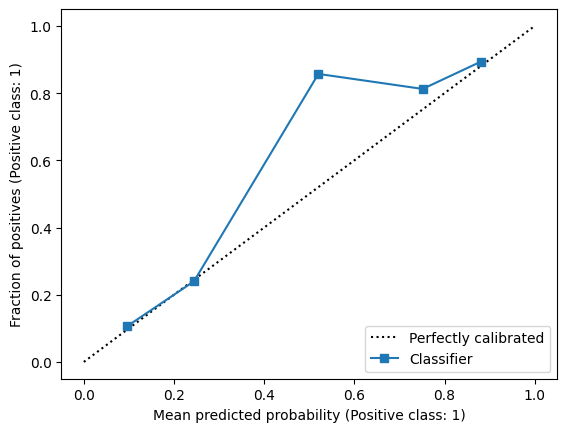

In [57]:
plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
disp = CalibrationDisplay.from_predictions(ty, ty_pred[:, 1])
plt.show()